In [27]:
!pip install mxnet=="1.4.1"

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [28]:
!pip install gluonts

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [29]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


In [30]:
dataname = "m4_daily"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily.


In [31]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length
print("length", len(dataset.train))

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])
length 4227


In [32]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily/train/data.json'), line=1), row=1)}

### Plot Series

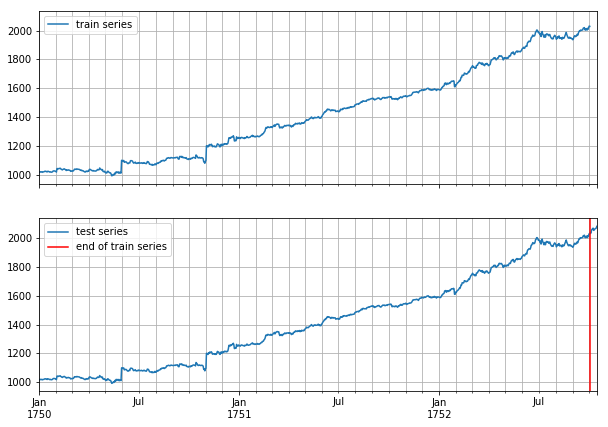

In [33]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [34]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-01 00:00:00
target: [1017.1 1019.3 1017.  1019.2 1018.7 1015.6 1018.5]
feat_static_cat: [0]
length: 4227


In [35]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.seq2seq import MQRNNEstimator


In [36]:
###########################
##### MQ-RNN wrapper ######

def mqrnn(data="m4_weekly", seed=42, epochs=100, num_batches=50):
    mx.random.seed(seed)
    np.random.seed(seed)

    dataset = get_dataset(data)

    trainer = Trainer(
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
        )

    estimator = MQRNNEstimator(
        trainer=trainer,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        )

    predictor=estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
            dataset.test, predictor=predictor, num_samples=100
        )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = num_batches

    df = pd.DataFrame([output])
    return df

## Results 

## `m4_daily`

In [47]:
results = pd.DataFrame()

for i in range(42, 45):
    print("Seed:", i)
    df = mqrnn(data="m4_daily", seed=i, epochs=1000, num_batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily.
INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]INFO:root:Number of parameters in ForkingSeq2SeqTrainingNetwork: 44243


Seed: 42


100%|██████████| 100/100 [00:02<00:00, 33.51it/s, avg_epoch_loss=2.17e+3]
INFO:root:Epoch[0] Elapsed time 2.986 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2166.392543
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.00it/s, avg_epoch_loss=1.97e+3]
INFO:root:Epoch[1] Elapsed time 2.634 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1967.165415
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.77it/s, avg_epoch_loss=2.15e+3]
INFO:root:Epoch[2] Elapsed time 2.722 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=2151.719813
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 40.41it/s, avg_epoch_loss=2.08e+3]
INFO:root:Epoch[3] Elapsed time 2.478 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2078.093933
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.45it/s, avg_epoch_loss=2.08e+3]
INFO:root:Epoch[4] Elapsed tim

100%|██████████| 100/100 [00:02<00:00, 39.10it/s, avg_epoch_loss=1.2e+3]
INFO:root:Epoch[36] Elapsed time 2.560 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=1195.330093
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.42it/s, avg_epoch_loss=1.16e+3]
INFO:root:Epoch[37] Elapsed time 2.677 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1162.740399
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.63it/s, avg_epoch_loss=969]
INFO:root:Epoch[38] Elapsed time 2.348 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=968.733152
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.87it/s, avg_epoch_loss=1.12e+3]
INFO:root:Epoch[39] Elapsed time 2.714 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1124.902947
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.44it/s, avg_epoch_loss=1.06e+3]
INFO:root:Epoch[40] Elap

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=920.110162
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.99it/s, avg_epoch_loss=933]
INFO:root:Epoch[73] Elapsed time 2.634 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=932.752200
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.23it/s, avg_epoch_loss=919]
INFO:root:Epoch[74] Elapsed time 2.763 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=918.952079
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 41.81it/s, avg_epoch_loss=756]
INFO:root:Epoch[75] Elapsed time 2.394 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=755.558630
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.05it/s, avg_epoch_loss=856]
INFO:root:Epoch[76] Elapsed time 2.702 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=856.030152
INFO:root:Epoch[77] Learning rate is 0.0005
10

INFO:root:Epoch[109] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 37.71it/s, avg_epoch_loss=517]
INFO:root:Epoch[109] Elapsed time 2.654 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=517.414502
INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 37.47it/s, avg_epoch_loss=552]
INFO:root:Epoch[110] Elapsed time 2.672 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=551.693250
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:03<00:00, 29.76it/s, avg_epoch_loss=544]
INFO:root:Epoch[111] Elapsed time 3.362 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=543.587976
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.10it/s, avg_epoch_loss=447]
INFO:root:Epoch[112] Elapsed time 2.435 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=447.268584
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.87it

INFO:root:Epoch[145] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 40.43it/s, avg_epoch_loss=310]
INFO:root:Epoch[145] Elapsed time 2.478 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=310.365606
INFO:root:Epoch[146] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.57it/s, avg_epoch_loss=387]
INFO:root:Epoch[146] Elapsed time 2.664 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=386.501577
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 38.09it/s, avg_epoch_loss=383]
INFO:root:Epoch[147] Elapsed time 2.627 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=383.489140
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 35.80it/s, avg_epoch_loss=394]
INFO:root:Epoch[148] Elapsed time 2.795 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=394.496732
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41

INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=303.739226
INFO:root:Epoch[181] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:02<00:00, 36.06it/s, avg_epoch_loss=304]
INFO:root:Epoch[181] Elapsed time 2.775 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=304.096582
INFO:root:Loading parameters from best epoch (161)
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.32it/s, avg_epoch_loss=251]
INFO:root:Epoch[182] Elapsed time 2.482 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=251.282276
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.32it/s, avg_epoch_loss=325]
INFO:root:Epoch[183] Elapsed time 2.681 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=325.096533
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.23it/s, avg_epoch_loss=313]
INFO:root:Epoch[184] Elapsed time 2.690 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_

INFO:root:Epoch[217] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.80it/s, avg_epoch_loss=259]
INFO:root:Epoch[217] Elapsed time 2.720 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=259.332027
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.18it/s, avg_epoch_loss=258]
INFO:root:Epoch[218] Elapsed time 2.766 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=258.393088
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.50it/s, avg_epoch_loss=201]
INFO:root:Epoch[219] Elapsed time 2.599 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=201.481586
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.74it/s, avg_epoch_loss=268]
INFO:root:Epoch[220] Elapsed time 2.800 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=267.787837
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.70it/s, avg_ep

100%|██████████| 100/100 [00:02<00:00, 37.68it/s, avg_epoch_loss=224]
INFO:root:Epoch[253] Elapsed time 2.656 seconds
INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=224.256103
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.27it/s, avg_epoch_loss=207]
INFO:root:Epoch[254] Elapsed time 2.687 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=206.547252
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.41it/s, avg_epoch_loss=210]
INFO:root:Epoch[255] Elapsed time 2.828 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=209.597171
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.47it/s, avg_epoch_loss=156]
INFO:root:Epoch[256] Elapsed time 2.472 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=156.380929
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.21it/s, avg_epoch_loss=219]
INFO:root:Epoch[257] Elapsed t

INFO:root:Epoch[289] Evaluation metric 'epoch_loss'=138.596661
INFO:root:Epoch[290] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.07it/s, avg_epoch_loss=191]
INFO:root:Epoch[290] Elapsed time 2.700 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=190.821371
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.19it/s, avg_epoch_loss=169]
INFO:root:Epoch[291] Elapsed time 2.765 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=168.569805
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.68it/s, avg_epoch_loss=176]
INFO:root:Epoch[292] Elapsed time 2.807 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=176.478073
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.09it/s, avg_epoch_loss=129]
INFO:root:Epoch[293] Elapsed time 2.496 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=128.536492
INFO:root:Epoch[294] Learning rate is

100%|██████████| 100/100 [00:02<00:00, 39.55it/s, avg_epoch_loss=115]
INFO:root:Epoch[326] Elapsed time 2.530 seconds
INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=114.581919
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.76it/s, avg_epoch_loss=155]
INFO:root:Epoch[327] Elapsed time 2.722 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=154.692966
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.31it/s, avg_epoch_loss=140]
INFO:root:Epoch[328] Elapsed time 2.682 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=140.177746
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.59it/s, avg_epoch_loss=153]
INFO:root:Epoch[329] Elapsed time 2.811 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=152.679553
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.66it/s, avg_epoch_loss=116]
INFO:root:Epoch[330] Elapsed t

INFO:root:Epoch[362] Evaluation metric 'epoch_loss'=133.548491
INFO:root:Epoch[363] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.59it/s, avg_epoch_loss=97.8]
INFO:root:Epoch[363] Elapsed time 2.529 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=97.756531
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.16it/s, avg_epoch_loss=139]
INFO:root:Epoch[364] Elapsed time 2.693 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=138.706719
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.21it/s, avg_epoch_loss=123]
INFO:root:Epoch[365] Elapsed time 2.689 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=123.317964
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.49it/s, avg_epoch_loss=131]
INFO:root:Epoch[366] Elapsed time 2.820 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=130.576300
INFO:root:Epoch[367] Learning rate is

100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_loss=113]
INFO:root:Epoch[399] Elapsed time 2.783 seconds
INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=112.686554
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.71it/s, avg_epoch_loss=82.8]
INFO:root:Epoch[400] Elapsed time 2.520 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=82.753864
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.33it/s, avg_epoch_loss=122]
INFO:root:Epoch[401] Elapsed time 2.754 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=121.968296
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.71it/s, avg_epoch_loss=111]
INFO:root:Epoch[402] Elapsed time 2.728 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=110.895335
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.30it/s, avg_epoch_loss=118]
INFO:root:Epoch[403] Elapsed t

INFO:root:Epoch[435] Evaluation metric 'epoch_loss'=96.547790
INFO:root:Epoch[436] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.77it/s, avg_epoch_loss=95.1]
INFO:root:Epoch[436] Elapsed time 2.797 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=95.086734
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.79it/s, avg_epoch_loss=69.1]
INFO:root:Epoch[437] Elapsed time 2.647 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=69.086216
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.01it/s, avg_epoch_loss=101]
INFO:root:Epoch[438] Elapsed time 2.703 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=101.330127
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.53it/s, avg_epoch_loss=92.8]
INFO:root:Epoch[439] Elapsed time 2.667 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=92.781084
INFO:root:Epoch[440] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 37.15it/s, avg_epoch_loss=99.8]
INFO:root:Epoch[472] Elapsed time 2.694 seconds
INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=99.847951
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.14it/s, avg_epoch_loss=92.3]
INFO:root:Epoch[473] Elapsed time 2.769 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=92.328052
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.09it/s, avg_epoch_loss=70.8]
INFO:root:Epoch[474] Elapsed time 2.497 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=70.807116
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.01it/s, avg_epoch_loss=92.4]
INFO:root:Epoch[475] Elapsed time 2.706 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=92.411127
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.68it/s, avg_epoch_loss=91.2]
INFO:root:Epoch[476] Elapsed 

INFO:root:Epoch[508] Evaluation metric 'epoch_loss'=91.536690
INFO:root:Epoch[509] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.30it/s, avg_epoch_loss=84.6]
INFO:root:Epoch[509] Elapsed time 2.685 seconds
INFO:root:Epoch[509] Evaluation metric 'epoch_loss'=84.561018
INFO:root:Epoch[510] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.94it/s, avg_epoch_loss=90.9]
INFO:root:Epoch[510] Elapsed time 2.786 seconds
INFO:root:Epoch[510] Evaluation metric 'epoch_loss'=90.884080
INFO:root:Epoch[511] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.86it/s, avg_epoch_loss=61.7]
INFO:root:Epoch[511] Elapsed time 2.645 seconds
INFO:root:Epoch[511] Evaluation metric 'epoch_loss'=61.698576
INFO:root:Epoch[512] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.37it/s, avg_epoch_loss=89.4]
INFO:root:Epoch[512] Elapsed time 3.295 seconds
INFO:root:Epoch[512] Evaluation metric 'epoch_loss'=89.397731
INFO:root:Epoch[513] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 37.63it/s, avg_epoch_loss=79.7]
INFO:root:Epoch[545] Elapsed time 2.661 seconds
INFO:root:Epoch[545] Evaluation metric 'epoch_loss'=79.695592
INFO:root:Epoch[546] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.38it/s, avg_epoch_loss=79.8]
INFO:root:Epoch[546] Elapsed time 2.752 seconds
INFO:root:Epoch[546] Evaluation metric 'epoch_loss'=79.801682
INFO:root:Epoch[547] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.89it/s, avg_epoch_loss=82.8]
INFO:root:Epoch[547] Elapsed time 2.791 seconds
INFO:root:Epoch[547] Evaluation metric 'epoch_loss'=82.816459
INFO:root:Epoch[548] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.42it/s, avg_epoch_loss=65.2]
INFO:root:Epoch[548] Elapsed time 2.476 seconds
INFO:root:Epoch[548] Evaluation metric 'epoch_loss'=65.184989
INFO:root:Epoch[549] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.53it/s, avg_epoch_loss=72.8]
INFO:root:Epoch[549] Elapsed 

INFO:root:Epoch[581] Evaluation metric 'epoch_loss'=61.732816
INFO:root:Epoch[582] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.59it/s, avg_epoch_loss=78.2]
INFO:root:Epoch[582] Elapsed time 2.662 seconds
INFO:root:Epoch[582] Evaluation metric 'epoch_loss'=78.164410
INFO:root:Epoch[583] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.31it/s, avg_epoch_loss=76.3]
INFO:root:Epoch[583] Elapsed time 2.836 seconds
INFO:root:Epoch[583] Evaluation metric 'epoch_loss'=76.284879
INFO:root:Epoch[584] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.20it/s, avg_epoch_loss=74.1]
INFO:root:Epoch[584] Elapsed time 2.927 seconds
INFO:root:Epoch[584] Evaluation metric 'epoch_loss'=74.080957
INFO:root:Epoch[585] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.18it/s, avg_epoch_loss=65.5]
INFO:root:Epoch[585] Elapsed time 2.555 seconds
INFO:root:Epoch[585] Evaluation metric 'epoch_loss'=65.482996
INFO:root:Epoch[586] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 39.66it/s, avg_epoch_loss=71.7]
INFO:root:Epoch[618] Elapsed time 2.523 seconds
INFO:root:Epoch[618] Evaluation metric 'epoch_loss'=71.722967
INFO:root:Epoch[619] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.36it/s, avg_epoch_loss=73.6]
INFO:root:Epoch[619] Elapsed time 2.681 seconds
INFO:root:Epoch[619] Evaluation metric 'epoch_loss'=73.635824
INFO:root:Epoch[620] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.39it/s, avg_epoch_loss=68.3]
INFO:root:Epoch[620] Elapsed time 2.677 seconds
INFO:root:Epoch[620] Evaluation metric 'epoch_loss'=68.302511
INFO:root:Epoch[621] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.10it/s, avg_epoch_loss=82.8]
INFO:root:Epoch[621] Elapsed time 2.850 seconds
INFO:root:Epoch[621] Evaluation metric 'epoch_loss'=82.803883
INFO:root:Epoch[622] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.83it/s, avg_epoch_loss=67.7]
INFO:root:Epoch[622] Elapsed 

INFO:root:Epoch[654] Evaluation metric 'epoch_loss'=95.032988
INFO:root:Epoch[655] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.68it/s, avg_epoch_loss=69]
INFO:root:Epoch[655] Elapsed time 2.524 seconds
INFO:root:Epoch[655] Evaluation metric 'epoch_loss'=69.005912
INFO:root:Epoch[656] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.26it/s, avg_epoch_loss=81.4]
INFO:root:Epoch[656] Elapsed time 2.686 seconds
INFO:root:Epoch[656] Evaluation metric 'epoch_loss'=81.437345
INFO:root:Epoch[657] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.48it/s, avg_epoch_loss=72.9]
INFO:root:Epoch[657] Elapsed time 2.672 seconds
INFO:root:Epoch[657] Evaluation metric 'epoch_loss'=72.874019
INFO:root:Epoch[658] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.39it/s, avg_epoch_loss=73.2]
INFO:root:Epoch[658] Elapsed time 2.830 seconds
INFO:root:Epoch[658] Evaluation metric 'epoch_loss'=73.150714
INFO:root:Epoch[659] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 36.27it/s, avg_epoch_loss=84.6]
INFO:root:Epoch[691] Elapsed time 2.759 seconds
INFO:root:Epoch[691] Evaluation metric 'epoch_loss'=84.632860
INFO:root:Epoch[692] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.06it/s, avg_epoch_loss=53.1]
INFO:root:Epoch[692] Elapsed time 2.498 seconds
INFO:root:Epoch[692] Evaluation metric 'epoch_loss'=53.093470
INFO:root:Epoch[693] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.21it/s, avg_epoch_loss=69.4]
INFO:root:Epoch[693] Elapsed time 2.689 seconds
INFO:root:Epoch[693] Evaluation metric 'epoch_loss'=69.367947
INFO:root:Epoch[694] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.47it/s, avg_epoch_loss=83.9]
INFO:root:Epoch[694] Elapsed time 2.673 seconds
INFO:root:Epoch[694] Evaluation metric 'epoch_loss'=83.868889
INFO:root:Epoch[695] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.31it/s, avg_epoch_loss=85.1]
INFO:root:Epoch[695] Elapsed 

INFO:root:Epoch[727] Evaluation metric 'epoch_loss'=73.635458
INFO:root:Epoch[728] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.91it/s, avg_epoch_loss=76.1]
INFO:root:Epoch[728] Elapsed time 2.787 seconds
INFO:root:Epoch[728] Evaluation metric 'epoch_loss'=76.144110
INFO:root:Epoch[729] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.73it/s, avg_epoch_loss=62]
INFO:root:Epoch[729] Elapsed time 2.519 seconds
INFO:root:Epoch[729] Evaluation metric 'epoch_loss'=61.976702
INFO:root:Epoch[730] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.93it/s, avg_epoch_loss=74.8]
INFO:root:Epoch[730] Elapsed time 2.710 seconds
INFO:root:Epoch[730] Evaluation metric 'epoch_loss'=74.848251
INFO:root:Epoch[731] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.57it/s, avg_epoch_loss=74.7]
INFO:root:Epoch[731] Elapsed time 2.666 seconds
INFO:root:Epoch[731] Evaluation metric 'epoch_loss'=74.725570
INFO:root:Epoch[732] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 37.02it/s, avg_epoch_loss=72.8]
INFO:root:Epoch[764] Elapsed time 2.706 seconds
INFO:root:Epoch[764] Evaluation metric 'epoch_loss'=72.764393
INFO:root:Epoch[765] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.62it/s, avg_epoch_loss=104]
INFO:root:Epoch[765] Elapsed time 2.812 seconds
INFO:root:Epoch[765] Evaluation metric 'epoch_loss'=103.524514
INFO:root:Epoch[766] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.19it/s, avg_epoch_loss=61.3]
INFO:root:Epoch[766] Elapsed time 2.492 seconds
INFO:root:Epoch[766] Evaluation metric 'epoch_loss'=61.347815
INFO:root:Epoch[767] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.73it/s, avg_epoch_loss=71.5]
INFO:root:Epoch[767] Elapsed time 2.727 seconds
INFO:root:Epoch[767] Evaluation metric 'epoch_loss'=71.492892
INFO:root:Epoch[768] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.38it/s, avg_epoch_loss=82.2]
INFO:root:Epoch[768] Elapsed 

INFO:root:Epoch[800] Evaluation metric 'epoch_loss'=74.847989
INFO:root:Epoch[801] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.13it/s, avg_epoch_loss=77.2]
INFO:root:Epoch[801] Elapsed time 2.850 seconds
INFO:root:Epoch[801] Evaluation metric 'epoch_loss'=77.160697
INFO:root:Epoch[802] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.61it/s, avg_epoch_loss=73.9]
INFO:root:Epoch[802] Elapsed time 2.810 seconds
INFO:root:Epoch[802] Evaluation metric 'epoch_loss'=73.906879
INFO:root:Epoch[803] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.38it/s, avg_epoch_loss=55.3]
INFO:root:Epoch[803] Elapsed time 2.610 seconds
INFO:root:Epoch[803] Evaluation metric 'epoch_loss'=55.284259
INFO:root:Epoch[804] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_loss=72.7]
INFO:root:Epoch[804] Elapsed time 2.880 seconds
INFO:root:Epoch[804] Evaluation metric 'epoch_loss'=72.654179
INFO:root:Epoch[805] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 37.24it/s, avg_epoch_loss=75.4]
INFO:root:Epoch[837] Elapsed time 2.687 seconds
INFO:root:Epoch[837] Evaluation metric 'epoch_loss'=75.403435
INFO:root:Epoch[838] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.99it/s, avg_epoch_loss=74.8]
INFO:root:Epoch[838] Elapsed time 2.707 seconds
INFO:root:Epoch[838] Evaluation metric 'epoch_loss'=74.789492
INFO:root:Epoch[839] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.43it/s, avg_epoch_loss=71.8]
INFO:root:Epoch[839] Elapsed time 2.825 seconds
INFO:root:Epoch[839] Evaluation metric 'epoch_loss'=71.827035
INFO:root:Epoch[840] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.11it/s, avg_epoch_loss=59.6]
INFO:root:Epoch[840] Elapsed time 2.496 seconds
INFO:root:Epoch[840] Evaluation metric 'epoch_loss'=59.586109
INFO:root:Epoch[841] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.27it/s, avg_epoch_loss=68.8]
INFO:root:Epoch[841] Elapsed 

INFO:root:Epoch[873] Evaluation metric 'epoch_loss'=53.965496
INFO:root:Epoch[874] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.09it/s, avg_epoch_loss=69.8]
INFO:root:Epoch[874] Elapsed time 2.698 seconds
INFO:root:Epoch[874] Evaluation metric 'epoch_loss'=69.779890
INFO:root:Epoch[875] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.03it/s, avg_epoch_loss=66.4]
INFO:root:Epoch[875] Elapsed time 2.704 seconds
INFO:root:Epoch[875] Evaluation metric 'epoch_loss'=66.377070
INFO:root:Epoch[876] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.78it/s, avg_epoch_loss=67.8]
INFO:root:Epoch[876] Elapsed time 2.966 seconds
INFO:root:Epoch[876] Evaluation metric 'epoch_loss'=67.775539
INFO:root:Epoch[877] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.65it/s, avg_epoch_loss=61.1]
INFO:root:Epoch[877] Elapsed time 2.461 seconds
INFO:root:Epoch[877] Evaluation metric 'epoch_loss'=61.128050
INFO:root:Epoch[878] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 39.59it/s, avg_epoch_loss=50.9]
INFO:root:Epoch[910] Elapsed time 2.528 seconds
INFO:root:Epoch[910] Evaluation metric 'epoch_loss'=50.885472
INFO:root:Epoch[911] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 30.22it/s, avg_epoch_loss=68.2]
INFO:root:Epoch[911] Elapsed time 3.311 seconds
INFO:root:Epoch[911] Evaluation metric 'epoch_loss'=68.203829
INFO:root:Epoch[912] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.75it/s, avg_epoch_loss=68.4]
INFO:root:Epoch[912] Elapsed time 2.723 seconds
INFO:root:Epoch[912] Evaluation metric 'epoch_loss'=68.409903
INFO:root:Epoch[913] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.15it/s, avg_epoch_loss=72.6]
INFO:root:Epoch[913] Elapsed time 2.849 seconds
INFO:root:Epoch[913] Evaluation metric 'epoch_loss'=72.572146
INFO:root:Epoch[914] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.40it/s, avg_epoch_loss=68.7]
INFO:root:Epoch[914] Elapsed 

INFO:root:Epoch[946] Evaluation metric 'epoch_loss'=69.100348
INFO:root:Epoch[947] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.25it/s, avg_epoch_loss=48.4]
INFO:root:Epoch[947] Elapsed time 2.550 seconds
INFO:root:Epoch[947] Evaluation metric 'epoch_loss'=48.413824
INFO:root:Epoch[948] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.41it/s, avg_epoch_loss=69.7]
INFO:root:Epoch[948] Elapsed time 2.749 seconds
INFO:root:Epoch[948] Evaluation metric 'epoch_loss'=69.728419
INFO:root:Epoch[949] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.85it/s, avg_epoch_loss=75.1]
INFO:root:Epoch[949] Elapsed time 2.718 seconds
INFO:root:Epoch[949] Evaluation metric 'epoch_loss'=75.143133
INFO:root:Epoch[950] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.86it/s, avg_epoch_loss=71.3]
INFO:root:Epoch[950] Elapsed time 2.872 seconds
INFO:root:Epoch[950] Evaluation metric 'epoch_loss'=71.261112
INFO:root:Epoch[951] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 33.79it/s, avg_epoch_loss=78.1]
INFO:root:Epoch[983] Elapsed time 2.961 seconds
INFO:root:Epoch[983] Evaluation metric 'epoch_loss'=78.107493
INFO:root:Epoch[984] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.86it/s, avg_epoch_loss=53]
INFO:root:Epoch[984] Elapsed time 2.645 seconds
INFO:root:Epoch[984] Evaluation metric 'epoch_loss'=53.030337
INFO:root:Epoch[985] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.70it/s, avg_epoch_loss=69.8]
INFO:root:Epoch[985] Elapsed time 2.729 seconds
INFO:root:Epoch[985] Evaluation metric 'epoch_loss'=69.819962
INFO:root:Epoch[986] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.35it/s, avg_epoch_loss=72.9]
INFO:root:Epoch[986] Elapsed time 2.681 seconds
INFO:root:Epoch[986] Evaluation metric 'epoch_loss'=72.887095
INFO:root:Epoch[987] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.89it/s, avg_epoch_loss=74.4]
INFO:root:Epoch[987] Elapsed ti

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  5.649771  0.041991  84.775571            0.046172            0.032503   

   seed  epochs  num_batches  
0    42    1000          100  
Seed: 43


100%|██████████| 100/100 [00:02<00:00, 33.82it/s, avg_epoch_loss=2.17e+3]
INFO:root:Epoch[0] Elapsed time 2.959 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2167.401056
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.21it/s, avg_epoch_loss=1.97e+3]
INFO:root:Epoch[1] Elapsed time 2.618 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1972.273643
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.21it/s, avg_epoch_loss=2.16e+3]
INFO:root:Epoch[2] Elapsed time 2.763 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=2163.993708
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.37it/s, avg_epoch_loss=2.1e+3]
INFO:root:Epoch[3] Elapsed time 2.610 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2100.989206
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.26it/s, avg_epoch_loss=2.11e+3]
INFO:root:Epoch[4] Elapsed time

100%|██████████| 100/100 [00:02<00:00, 38.83it/s, avg_epoch_loss=1.13e+3]
INFO:root:Epoch[36] Elapsed time 2.579 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=1133.546271
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.11it/s, avg_epoch_loss=1.11e+3]
INFO:root:Epoch[37] Elapsed time 2.697 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1109.569827
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 42.30it/s, avg_epoch_loss=937]
INFO:root:Epoch[38] Elapsed time 2.367 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=936.504994
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.49it/s, avg_epoch_loss=1.09e+3]
INFO:root:Epoch[39] Elapsed time 2.670 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1087.160647
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.10it/s, avg_epoch_loss=1.04e+3]
INFO:root:Epoch[40] Ela

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=681.478960
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.64it/s, avg_epoch_loss=691]
INFO:root:Epoch[73] Elapsed time 2.660 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=691.001826
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.23it/s, avg_epoch_loss=663]
INFO:root:Epoch[74] Elapsed time 2.764 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=663.214289
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 40.80it/s, avg_epoch_loss=531]
INFO:root:Epoch[75] Elapsed time 2.454 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=531.130317
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.39it/s, avg_epoch_loss=619]
INFO:root:Epoch[76] Elapsed time 2.749 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=619.125495
INFO:root:Epoch[77] Learning rate is 0.0005
10

100%|██████████| 100/100 [00:02<00:00, 37.59it/s, avg_epoch_loss=403]
INFO:root:Epoch[109] Elapsed time 2.662 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=402.801833
INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 36.47it/s, avg_epoch_loss=404]
INFO:root:Epoch[110] Elapsed time 2.746 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=403.843936
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.78it/s, avg_epoch_loss=459]
INFO:root:Epoch[111] Elapsed time 2.798 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=459.267383
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 41.26it/s, avg_epoch_loss=359]
INFO:root:Epoch[112] Elapsed time 2.428 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=358.882554
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 36.40it/s, avg_epoch_loss=429]
INFO:root:Epoch[113] E

INFO:root:Epoch[145] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 39.87it/s, avg_epoch_loss=201]
INFO:root:Epoch[145] Elapsed time 2.511 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=200.801801
INFO:root:Epoch[146] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.68it/s, avg_epoch_loss=252]
INFO:root:Epoch[146] Elapsed time 2.728 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=251.691806
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 37.81it/s, avg_epoch_loss=217]
INFO:root:Epoch[147] Elapsed time 2.647 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=217.123754
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 35.24it/s, avg_epoch_loss=287]
INFO:root:Epoch[148] Elapsed time 2.840 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=286.803357
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 41

INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=167.814038
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.86it/s, avg_epoch_loss=179]
INFO:root:Epoch[181] Elapsed time 2.792 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=179.393409
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.37it/s, avg_epoch_loss=127]
INFO:root:Epoch[182] Elapsed time 2.610 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=127.259887
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.38it/s, avg_epoch_loss=186]
INFO:root:Epoch[183] Elapsed time 2.750 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=185.902636
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.26it/s, avg_epoch_loss=165]
INFO:root:Epoch[184] Elapsed time 2.687 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=164.530131
INFO:root:Epoch[185] Learning rate is

100%|██████████| 100/100 [00:02<00:00, 36.98it/s, avg_epoch_loss=167]
INFO:root:Epoch[217] Elapsed time 2.706 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=167.337579
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.67it/s, avg_epoch_loss=169]
INFO:root:Epoch[218] Elapsed time 2.805 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=169.294873
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.95it/s, avg_epoch_loss=128]
INFO:root:Epoch[219] Elapsed time 2.505 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=128.437210
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.30it/s, avg_epoch_loss=180]
INFO:root:Epoch[220] Elapsed time 2.758 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=179.839275
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.53it/s, avg_epoch_loss=160]
INFO:root:Epoch[221] Elapsed t

INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=139.880387
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.70it/s, avg_epoch_loss=126]
INFO:root:Epoch[254] Elapsed time 2.729 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=125.895289
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.33it/s, avg_epoch_loss=136]
INFO:root:Epoch[255] Elapsed time 2.832 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=136.488594
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.32it/s, avg_epoch_loss=94.8]
INFO:root:Epoch[256] Elapsed time 2.613 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=94.781673
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.13it/s, avg_epoch_loss=117]
INFO:root:Epoch[257] Elapsed time 2.848 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=116.546960
INFO:root:Epoch[258] Learning rate is

100%|██████████| 100/100 [00:02<00:00, 36.88it/s, avg_epoch_loss=110]
INFO:root:Epoch[290] Elapsed time 2.713 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=109.842328
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.12it/s, avg_epoch_loss=113]
INFO:root:Epoch[291] Elapsed time 2.697 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=113.412749
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.59it/s, avg_epoch_loss=108]
INFO:root:Epoch[292] Elapsed time 2.812 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=107.792867
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.67it/s, avg_epoch_loss=87.2]
INFO:root:Epoch[293] Elapsed time 2.525 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=87.184697
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.25it/s, avg_epoch_loss=101]
INFO:root:Epoch[294] Elapsed t

INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=74.652077
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.55it/s, avg_epoch_loss=98.9]
INFO:root:Epoch[327] Elapsed time 2.738 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=98.861822
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.00it/s, avg_epoch_loss=89]
INFO:root:Epoch[328] Elapsed time 2.705 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=89.027266
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.28it/s, avg_epoch_loss=97]
INFO:root:Epoch[329] Elapsed time 2.837 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=97.040033
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.07it/s, avg_epoch_loss=75.7]
INFO:root:Epoch[330] Elapsed time 2.497 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=75.685343
INFO:root:Epoch[331] Learning rate is 5e-0

100%|██████████| 100/100 [00:02<00:00, 38.71it/s, avg_epoch_loss=68.8]
INFO:root:Epoch[363] Elapsed time 2.585 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=68.750583
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.50it/s, avg_epoch_loss=100]
INFO:root:Epoch[364] Elapsed time 3.079 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=100.086842
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.26it/s, avg_epoch_loss=85.8]
INFO:root:Epoch[365] Elapsed time 3.201 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=85.843779
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.83it/s, avg_epoch_loss=94.3]
INFO:root:Epoch[366] Elapsed time 2.875 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=94.337357
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.16it/s, avg_epoch_loss=78.2]
INFO:root:Epoch[367] Elapsed 

INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=92.599555
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.07it/s, avg_epoch_loss=66.7]
INFO:root:Epoch[400] Elapsed time 2.561 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=66.713355
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.51it/s, avg_epoch_loss=94.5]
INFO:root:Epoch[401] Elapsed time 2.741 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=94.455284
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.34it/s, avg_epoch_loss=89.7]
INFO:root:Epoch[402] Elapsed time 2.755 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=89.721948
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.07it/s, avg_epoch_loss=88.9]
INFO:root:Epoch[403] Elapsed time 2.938 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=88.858236
INFO:root:Epoch[404] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 34.87it/s, avg_epoch_loss=83.7]
INFO:root:Epoch[436] Elapsed time 2.869 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=83.690277
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.91it/s, avg_epoch_loss=69.3]
INFO:root:Epoch[437] Elapsed time 2.575 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=69.263615
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.67it/s, avg_epoch_loss=90.9]
INFO:root:Epoch[438] Elapsed time 2.888 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=90.878050
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.51it/s, avg_epoch_loss=85]
INFO:root:Epoch[439] Elapsed time 2.741 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=85.002780
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.14it/s, avg_epoch_loss=91.9]
INFO:root:Epoch[440] Elapsed ti

INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=80.864626
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.16it/s, avg_epoch_loss=85.6]
INFO:root:Epoch[473] Elapsed time 2.847 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=85.606227
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.05it/s, avg_epoch_loss=71.5]
INFO:root:Epoch[474] Elapsed time 2.563 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=71.510876
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.72it/s, avg_epoch_loss=81.8]
INFO:root:Epoch[475] Elapsed time 2.803 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=81.824528
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.68it/s, avg_epoch_loss=82.1]
INFO:root:Epoch[476] Elapsed time 2.728 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=82.136545
INFO:root:Epoch[477] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 36.34it/s, avg_epoch_loss=73.8]
INFO:root:Epoch[509] Elapsed time 2.754 seconds
INFO:root:Epoch[509] Evaluation metric 'epoch_loss'=73.774849
INFO:root:Epoch[510] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.04it/s, avg_epoch_loss=88.7]
INFO:root:Epoch[510] Elapsed time 2.857 seconds
INFO:root:Epoch[510] Evaluation metric 'epoch_loss'=88.684799
INFO:root:Epoch[511] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.37it/s, avg_epoch_loss=61]
INFO:root:Epoch[511] Elapsed time 2.542 seconds
INFO:root:Epoch[511] Evaluation metric 'epoch_loss'=61.002884
INFO:root:Epoch[512] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.62it/s, avg_epoch_loss=80.6]
INFO:root:Epoch[512] Elapsed time 2.891 seconds
INFO:root:Epoch[512] Evaluation metric 'epoch_loss'=80.646522
INFO:root:Epoch[513] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.17it/s, avg_epoch_loss=79.2]
INFO:root:Epoch[513] Elapsed ti

INFO:root:Epoch[545] Evaluation metric 'epoch_loss'=76.152783
INFO:root:Epoch[546] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.17it/s, avg_epoch_loss=71.6]
INFO:root:Epoch[546] Elapsed time 2.845 seconds
INFO:root:Epoch[546] Evaluation metric 'epoch_loss'=71.586961
INFO:root:Epoch[547] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.82it/s, avg_epoch_loss=81.7]
INFO:root:Epoch[547] Elapsed time 2.877 seconds
INFO:root:Epoch[547] Evaluation metric 'epoch_loss'=81.682445
INFO:root:Epoch[548] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.90it/s, avg_epoch_loss=70]
INFO:root:Epoch[548] Elapsed time 2.574 seconds
INFO:root:Epoch[548] Evaluation metric 'epoch_loss'=69.998996
INFO:root:Epoch[549] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.72it/s, avg_epoch_loss=74.1]
INFO:root:Epoch[549] Elapsed time 2.801 seconds
INFO:root:Epoch[549] Evaluation metric 'epoch_loss'=74.149228
INFO:root:Epoch[550] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 36.25it/s, avg_epoch_loss=78.1]
INFO:root:Epoch[582] Elapsed time 2.760 seconds
INFO:root:Epoch[582] Evaluation metric 'epoch_loss'=78.141345
INFO:root:Epoch[583] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.15it/s, avg_epoch_loss=75.7]
INFO:root:Epoch[583] Elapsed time 2.770 seconds
INFO:root:Epoch[583] Evaluation metric 'epoch_loss'=75.747054
INFO:root:Epoch[584] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.74it/s, avg_epoch_loss=83]
INFO:root:Epoch[584] Elapsed time 3.154 seconds
INFO:root:Epoch[584] Evaluation metric 'epoch_loss'=82.969530
INFO:root:Epoch[585] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.41it/s, avg_epoch_loss=70.5]
INFO:root:Epoch[585] Elapsed time 2.539 seconds
INFO:root:Epoch[585] Evaluation metric 'epoch_loss'=70.491477
INFO:root:Epoch[586] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.60it/s, avg_epoch_loss=69.8]
INFO:root:Epoch[586] Elapsed ti

INFO:root:Epoch[618] Evaluation metric 'epoch_loss'=53.284427
INFO:root:Epoch[619] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.23it/s, avg_epoch_loss=82.3]
INFO:root:Epoch[619] Elapsed time 2.762 seconds
INFO:root:Epoch[619] Evaluation metric 'epoch_loss'=82.272384
INFO:root:Epoch[620] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.05it/s, avg_epoch_loss=69.5]
INFO:root:Epoch[620] Elapsed time 2.857 seconds
INFO:root:Epoch[620] Evaluation metric 'epoch_loss'=69.480594
INFO:root:Epoch[621] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.47it/s, avg_epoch_loss=78.5]
INFO:root:Epoch[621] Elapsed time 2.991 seconds
INFO:root:Epoch[621] Evaluation metric 'epoch_loss'=78.454609
INFO:root:Epoch[622] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.16it/s, avg_epoch_loss=70.2]
INFO:root:Epoch[622] Elapsed time 2.624 seconds
INFO:root:Epoch[622] Evaluation metric 'epoch_loss'=70.208950
INFO:root:Epoch[623] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 38.61it/s, avg_epoch_loss=56.3]
INFO:root:Epoch[655] Elapsed time 2.592 seconds
INFO:root:Epoch[655] Evaluation metric 'epoch_loss'=56.264117
INFO:root:Epoch[656] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.99it/s, avg_epoch_loss=80]
INFO:root:Epoch[656] Elapsed time 2.860 seconds
INFO:root:Epoch[656] Evaluation metric 'epoch_loss'=79.979854
INFO:root:Epoch[657] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.54it/s, avg_epoch_loss=75.4]
INFO:root:Epoch[657] Elapsed time 2.739 seconds
INFO:root:Epoch[657] Evaluation metric 'epoch_loss'=75.352515
INFO:root:Epoch[658] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.49it/s, avg_epoch_loss=85.4]
INFO:root:Epoch[658] Elapsed time 2.901 seconds
INFO:root:Epoch[658] Evaluation metric 'epoch_loss'=85.446160
INFO:root:Epoch[659] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.34it/s, avg_epoch_loss=68.1]
INFO:root:Epoch[659] Elapsed ti

INFO:root:Epoch[691] Evaluation metric 'epoch_loss'=80.906755
INFO:root:Epoch[692] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.54it/s, avg_epoch_loss=69.4]
INFO:root:Epoch[692] Elapsed time 2.599 seconds
INFO:root:Epoch[692] Evaluation metric 'epoch_loss'=69.354316
INFO:root:Epoch[693] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.44it/s, avg_epoch_loss=100]
INFO:root:Epoch[693] Elapsed time 2.825 seconds
INFO:root:Epoch[693] Evaluation metric 'epoch_loss'=100.161252
INFO:root:Epoch[694] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.60it/s, avg_epoch_loss=70]
INFO:root:Epoch[694] Elapsed time 2.735 seconds
INFO:root:Epoch[694] Evaluation metric 'epoch_loss'=70.033372
INFO:root:Epoch[695] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.99it/s, avg_epoch_loss=80.7]
INFO:root:Epoch[695] Elapsed time 3.036 seconds
INFO:root:Epoch[695] Evaluation metric 'epoch_loss'=80.679849
INFO:root:Epoch[696] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 34.97it/s, avg_epoch_loss=73.5]
INFO:root:Epoch[728] Elapsed time 2.862 seconds
INFO:root:Epoch[728] Evaluation metric 'epoch_loss'=73.542686
INFO:root:Epoch[729] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.64it/s, avg_epoch_loss=66.2]
INFO:root:Epoch[729] Elapsed time 2.590 seconds
INFO:root:Epoch[729] Evaluation metric 'epoch_loss'=66.228318
INFO:root:Epoch[730] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.50it/s, avg_epoch_loss=73]
INFO:root:Epoch[730] Elapsed time 2.820 seconds
INFO:root:Epoch[730] Evaluation metric 'epoch_loss'=73.036154
INFO:root:Epoch[731] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.02it/s, avg_epoch_loss=70.8]
INFO:root:Epoch[731] Elapsed time 2.779 seconds
INFO:root:Epoch[731] Evaluation metric 'epoch_loss'=70.842676
INFO:root:Epoch[732] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 32.71it/s, avg_epoch_loss=85.6]
INFO:root:Epoch[732] Elapsed ti

INFO:root:Epoch[764] Evaluation metric 'epoch_loss'=77.936290
INFO:root:Epoch[765] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.58it/s, avg_epoch_loss=76.7]
INFO:root:Epoch[765] Elapsed time 2.894 seconds
INFO:root:Epoch[765] Evaluation metric 'epoch_loss'=76.740783
INFO:root:Epoch[766] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.69it/s, avg_epoch_loss=61.1]
INFO:root:Epoch[766] Elapsed time 2.587 seconds
INFO:root:Epoch[766] Evaluation metric 'epoch_loss'=61.050258
INFO:root:Epoch[767] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.62it/s, avg_epoch_loss=76.6]
INFO:root:Epoch[767] Elapsed time 2.809 seconds
INFO:root:Epoch[767] Evaluation metric 'epoch_loss'=76.613914
INFO:root:Epoch[768] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.67it/s, avg_epoch_loss=70.3]
INFO:root:Epoch[768] Elapsed time 2.731 seconds
INFO:root:Epoch[768] Evaluation metric 'epoch_loss'=70.332251
INFO:root:Epoch[769] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 34.76it/s, avg_epoch_loss=71.6]
INFO:root:Epoch[801] Elapsed time 2.881 seconds
INFO:root:Epoch[801] Evaluation metric 'epoch_loss'=71.603322
INFO:root:Epoch[802] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.08it/s, avg_epoch_loss=69.5]
INFO:root:Epoch[802] Elapsed time 2.938 seconds
INFO:root:Epoch[802] Evaluation metric 'epoch_loss'=69.549273
INFO:root:Epoch[803] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.82it/s, avg_epoch_loss=60.6]
INFO:root:Epoch[803] Elapsed time 2.580 seconds
INFO:root:Epoch[803] Evaluation metric 'epoch_loss'=60.580363
INFO:root:Epoch[804] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.54it/s, avg_epoch_loss=88.5]
INFO:root:Epoch[804] Elapsed time 2.816 seconds
INFO:root:Epoch[804] Evaluation metric 'epoch_loss'=88.527224
INFO:root:Epoch[805] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.89it/s, avg_epoch_loss=76.7]
INFO:root:Epoch[805] Elapsed 

INFO:root:Epoch[837] Evaluation metric 'epoch_loss'=70.776324
INFO:root:Epoch[838] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.01it/s, avg_epoch_loss=71.1]
INFO:root:Epoch[838] Elapsed time 2.778 seconds
INFO:root:Epoch[838] Evaluation metric 'epoch_loss'=71.085798
INFO:root:Epoch[839] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.44it/s, avg_epoch_loss=75.9]
INFO:root:Epoch[839] Elapsed time 2.907 seconds
INFO:root:Epoch[839] Evaluation metric 'epoch_loss'=75.865671
INFO:root:Epoch[840] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.98it/s, avg_epoch_loss=66.5]
INFO:root:Epoch[840] Elapsed time 2.569 seconds
INFO:root:Epoch[840] Evaluation metric 'epoch_loss'=66.520577
INFO:root:Epoch[841] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.25it/s, avg_epoch_loss=69.7]
INFO:root:Epoch[841] Elapsed time 2.841 seconds
INFO:root:Epoch[841] Evaluation metric 'epoch_loss'=69.710319
INFO:root:Epoch[842] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_loss=70.6]
INFO:root:Epoch[874] Elapsed time 2.830 seconds
INFO:root:Epoch[874] Evaluation metric 'epoch_loss'=70.645236
INFO:root:Epoch[875] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.90it/s, avg_epoch_loss=69.6]
INFO:root:Epoch[875] Elapsed time 2.788 seconds
INFO:root:Epoch[875] Evaluation metric 'epoch_loss'=69.617519
INFO:root:Epoch[876] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.21it/s, avg_epoch_loss=80.2]
INFO:root:Epoch[876] Elapsed time 2.927 seconds
INFO:root:Epoch[876] Evaluation metric 'epoch_loss'=80.242576
INFO:root:Epoch[877] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.31it/s, avg_epoch_loss=67]
INFO:root:Epoch[877] Elapsed time 2.546 seconds
INFO:root:Epoch[877] Evaluation metric 'epoch_loss'=66.990193
INFO:root:Epoch[878] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.35it/s, avg_epoch_loss=67.1]
INFO:root:Epoch[878] Elapsed ti

INFO:root:Epoch[910] Evaluation metric 'epoch_loss'=54.139339
INFO:root:Epoch[911] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.79it/s, avg_epoch_loss=65.3]
INFO:root:Epoch[911] Elapsed time 2.798 seconds
INFO:root:Epoch[911] Evaluation metric 'epoch_loss'=65.261677
INFO:root:Epoch[912] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.16it/s, avg_epoch_loss=74.1]
INFO:root:Epoch[912] Elapsed time 2.770 seconds
INFO:root:Epoch[912] Evaluation metric 'epoch_loss'=74.080238
INFO:root:Epoch[913] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.29it/s, avg_epoch_loss=77.3]
INFO:root:Epoch[913] Elapsed time 2.920 seconds
INFO:root:Epoch[913] Evaluation metric 'epoch_loss'=77.261505
INFO:root:Epoch[914] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.09it/s, avg_epoch_loss=64.8]
INFO:root:Epoch[914] Elapsed time 2.562 seconds
INFO:root:Epoch[914] Evaluation metric 'epoch_loss'=64.796233
INFO:root:Epoch[915] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 34.59it/s, avg_epoch_loss=48.2]
INFO:root:Epoch[947] Elapsed time 2.895 seconds
INFO:root:Epoch[947] Evaluation metric 'epoch_loss'=48.183318
INFO:root:Epoch[948] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.85it/s, avg_epoch_loss=68.2]
INFO:root:Epoch[948] Elapsed time 3.141 seconds
INFO:root:Epoch[948] Evaluation metric 'epoch_loss'=68.215715
INFO:root:Epoch[949] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.87it/s, avg_epoch_loss=66.1]
INFO:root:Epoch[949] Elapsed time 2.789 seconds
INFO:root:Epoch[949] Evaluation metric 'epoch_loss'=66.072484
INFO:root:Epoch[950] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.04it/s, avg_epoch_loss=71.5]
INFO:root:Epoch[950] Elapsed time 2.939 seconds
INFO:root:Epoch[950] Evaluation metric 'epoch_loss'=71.541001
INFO:root:Epoch[951] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.42it/s, avg_epoch_loss=58.7]
INFO:root:Epoch[951] Elapsed 

INFO:root:Epoch[983] Evaluation metric 'epoch_loss'=88.413917
INFO:root:Epoch[984] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.91it/s, avg_epoch_loss=66.1]
INFO:root:Epoch[984] Elapsed time 2.574 seconds
INFO:root:Epoch[984] Evaluation metric 'epoch_loss'=66.134023
INFO:root:Epoch[985] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.01it/s, avg_epoch_loss=66.3]
INFO:root:Epoch[985] Elapsed time 2.781 seconds
INFO:root:Epoch[985] Evaluation metric 'epoch_loss'=66.323291
INFO:root:Epoch[986] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.88it/s, avg_epoch_loss=68.3]
INFO:root:Epoch[986] Elapsed time 2.791 seconds
INFO:root:Epoch[986] Evaluation metric 'epoch_loss'=68.347569
INFO:root:Epoch[987] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.05it/s, avg_epoch_loss=69.8]
INFO:root:Epoch[987] Elapsed time 2.940 seconds
INFO:root:Epoch[987] Evaluation metric 'epoch_loss'=69.764447
INFO:root:Epoch[988] Learning rate is 

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  6.398807  0.048037  107.512683            0.053392            0.043068   

   seed  epochs  num_batches  
0    43    1000          100  
Seed: 44


100%|██████████| 100/100 [00:03<00:00, 28.58it/s, avg_epoch_loss=2.17e+3]
INFO:root:Epoch[0] Elapsed time 3.501 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2166.601251
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 37.80it/s, avg_epoch_loss=1.97e+3]
INFO:root:Epoch[1] Elapsed time 2.647 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1970.240608
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 35.99it/s, avg_epoch_loss=2.16e+3]
INFO:root:Epoch[2] Elapsed time 2.781 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=2159.634065
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 39.63it/s, avg_epoch_loss=2.09e+3]
INFO:root:Epoch[3] Elapsed time 2.528 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=2091.987273
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.36it/s, avg_epoch_loss=2.1e+3]
INFO:root:Epoch[4] Elapsed time

100%|██████████| 100/100 [00:02<00:00, 38.37it/s, avg_epoch_loss=1.25e+3]
INFO:root:Epoch[36] Elapsed time 2.609 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=1253.189109
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.76it/s, avg_epoch_loss=1.29e+3]
INFO:root:Epoch[37] Elapsed time 2.722 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=1287.490261
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 41.93it/s, avg_epoch_loss=1.04e+3]
INFO:root:Epoch[38] Elapsed time 2.387 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=1042.772518
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 36.54it/s, avg_epoch_loss=1.15e+3]
INFO:root:Epoch[39] Elapsed time 2.738 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=1152.062963
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:02<00:00, 38.93it/s, avg_epoch_loss=1.08e+3]
INFO:root:Epoch[40

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=647.390483
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 37.60it/s, avg_epoch_loss=639]
INFO:root:Epoch[73] Elapsed time 2.661 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=638.727120
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 35.73it/s, avg_epoch_loss=632]
INFO:root:Epoch[74] Elapsed time 2.801 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=631.752641
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 39.56it/s, avg_epoch_loss=490]
INFO:root:Epoch[75] Elapsed time 2.531 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=489.589555
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:02<00:00, 36.32it/s, avg_epoch_loss=614]
INFO:root:Epoch[76] Elapsed time 2.754 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=614.345098
INFO:root:Epoch[77] Learning rate is 0.0005
10

100%|██████████| 100/100 [00:02<00:00, 36.72it/s, avg_epoch_loss=333]
INFO:root:Epoch[109] Elapsed time 2.726 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=332.706729
INFO:root:Epoch[110] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 36.59it/s, avg_epoch_loss=329]
INFO:root:Epoch[110] Elapsed time 2.736 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=329.364458
INFO:root:Epoch[111] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 34.83it/s, avg_epoch_loss=367]
INFO:root:Epoch[111] Elapsed time 2.875 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=366.542122
INFO:root:Epoch[112] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 40.22it/s, avg_epoch_loss=265]
INFO:root:Epoch[112] Elapsed time 2.488 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=265.238697
INFO:root:Epoch[113] Learning rate is 0.00025
100%|██████████| 100/100 [00:02<00:00, 35.08it/s, avg_epoch_loss=322]
INFO:root:Epoch[113] E

100%|██████████| 100/100 [00:02<00:00, 38.88it/s, avg_epoch_loss=176]
INFO:root:Epoch[145] Elapsed time 2.573 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=176.168156
INFO:root:Epoch[146] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.23it/s, avg_epoch_loss=227]
INFO:root:Epoch[146] Elapsed time 2.762 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=227.002877
INFO:root:Epoch[147] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 36.41it/s, avg_epoch_loss=195]
INFO:root:Epoch[147] Elapsed time 2.748 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=195.167088
INFO:root:Epoch[148] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 34.50it/s, avg_epoch_loss=199]
INFO:root:Epoch[148] Elapsed time 2.902 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=198.860594
INFO:root:Epoch[149] Learning rate is 0.000125
100%|██████████| 100/100 [00:02<00:00, 39.77it/s, avg_epoch_loss=167]
INFO:root:Epoch[14

INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.38it/s, avg_epoch_loss=168]
INFO:root:Epoch[181] Elapsed time 2.829 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=167.995865
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.79it/s, avg_epoch_loss=125]
INFO:root:Epoch[182] Elapsed time 2.581 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=124.656012
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.62it/s, avg_epoch_loss=181]
INFO:root:Epoch[183] Elapsed time 2.809 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=180.522271
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.82it/s, avg_epoch_loss=167]
INFO:root:Epoch[184] Elapsed time 2.793 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=167.421316
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.49it/s, avg_ep

100%|██████████| 100/100 [00:02<00:00, 36.26it/s, avg_epoch_loss=135]
INFO:root:Epoch[217] Elapsed time 2.760 seconds
INFO:root:Epoch[217] Evaluation metric 'epoch_loss'=135.158611
INFO:root:Epoch[218] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.08it/s, avg_epoch_loss=139]
INFO:root:Epoch[218] Elapsed time 2.853 seconds
INFO:root:Epoch[218] Evaluation metric 'epoch_loss'=139.286497
INFO:root:Epoch[219] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.80it/s, avg_epoch_loss=105]
INFO:root:Epoch[219] Elapsed time 2.578 seconds
INFO:root:Epoch[219] Evaluation metric 'epoch_loss'=104.951957
INFO:root:Epoch[220] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.09it/s, avg_epoch_loss=142]
INFO:root:Epoch[220] Elapsed time 2.773 seconds
INFO:root:Epoch[220] Evaluation metric 'epoch_loss'=141.999873
INFO:root:Epoch[221] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.77it/s, avg_epoch_loss=130]
INFO:root:Epoch[221] Elapsed t

INFO:root:Epoch[253] Evaluation metric 'epoch_loss'=125.177291
INFO:root:Epoch[254] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.74it/s, avg_epoch_loss=112]
INFO:root:Epoch[254] Elapsed time 2.725 seconds
INFO:root:Epoch[254] Evaluation metric 'epoch_loss'=111.706398
INFO:root:Epoch[255] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.19it/s, avg_epoch_loss=115]
INFO:root:Epoch[255] Elapsed time 2.844 seconds
INFO:root:Epoch[255] Evaluation metric 'epoch_loss'=114.650508
INFO:root:Epoch[256] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.45it/s, avg_epoch_loss=87.9]
INFO:root:Epoch[256] Elapsed time 2.536 seconds
INFO:root:Epoch[256] Evaluation metric 'epoch_loss'=87.879689
INFO:root:Epoch[257] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.96it/s, avg_epoch_loss=121]
INFO:root:Epoch[257] Elapsed time 2.783 seconds
INFO:root:Epoch[257] Evaluation metric 'epoch_loss'=120.539400
INFO:root:Epoch[258] Learning rate is

100%|██████████| 100/100 [00:02<00:00, 36.91it/s, avg_epoch_loss=116]
INFO:root:Epoch[290] Elapsed time 2.711 seconds
INFO:root:Epoch[290] Evaluation metric 'epoch_loss'=116.231757
INFO:root:Epoch[291] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.12it/s, avg_epoch_loss=99.1]
INFO:root:Epoch[291] Elapsed time 2.773 seconds
INFO:root:Epoch[291] Evaluation metric 'epoch_loss'=99.054321
INFO:root:Epoch[292] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.14it/s, avg_epoch_loss=103]
INFO:root:Epoch[292] Elapsed time 2.848 seconds
INFO:root:Epoch[292] Evaluation metric 'epoch_loss'=103.261741
INFO:root:Epoch[293] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.83it/s, avg_epoch_loss=78]
INFO:root:Epoch[293] Elapsed time 2.514 seconds
INFO:root:Epoch[293] Evaluation metric 'epoch_loss'=77.971458
INFO:root:Epoch[294] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.76it/s, avg_epoch_loss=116]
INFO:root:Epoch[294] Elapsed tim

INFO:root:Epoch[326] Evaluation metric 'epoch_loss'=73.229835
INFO:root:Epoch[327] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.19it/s, avg_epoch_loss=102]
INFO:root:Epoch[327] Elapsed time 2.844 seconds
INFO:root:Epoch[327] Evaluation metric 'epoch_loss'=101.567320
INFO:root:Epoch[328] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.72it/s, avg_epoch_loss=90.2]
INFO:root:Epoch[328] Elapsed time 2.725 seconds
INFO:root:Epoch[328] Evaluation metric 'epoch_loss'=90.170889
INFO:root:Epoch[329] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=101]
INFO:root:Epoch[329] Elapsed time 2.877 seconds
INFO:root:Epoch[329] Evaluation metric 'epoch_loss'=101.286666
INFO:root:Epoch[330] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 31.97it/s, avg_epoch_loss=83]
INFO:root:Epoch[330] Elapsed time 3.130 seconds
INFO:root:Epoch[330] Evaluation metric 'epoch_loss'=82.990592
INFO:root:Epoch[331] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 39.09it/s, avg_epoch_loss=75.6]
INFO:root:Epoch[363] Elapsed time 2.562 seconds
INFO:root:Epoch[363] Evaluation metric 'epoch_loss'=75.554342
INFO:root:Epoch[364] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.11it/s, avg_epoch_loss=93.1]
INFO:root:Epoch[364] Elapsed time 2.851 seconds
INFO:root:Epoch[364] Evaluation metric 'epoch_loss'=93.072661
INFO:root:Epoch[365] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.90it/s, avg_epoch_loss=85.7]
INFO:root:Epoch[365] Elapsed time 2.712 seconds
INFO:root:Epoch[365] Evaluation metric 'epoch_loss'=85.690059
INFO:root:Epoch[366] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.01it/s, avg_epoch_loss=99.8]
INFO:root:Epoch[366] Elapsed time 2.860 seconds
INFO:root:Epoch[366] Evaluation metric 'epoch_loss'=99.833396
INFO:root:Epoch[367] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.39it/s, avg_epoch_loss=77]
INFO:root:Epoch[367] Elapsed ti

INFO:root:Epoch[399] Evaluation metric 'epoch_loss'=86.264674
INFO:root:Epoch[400] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.17it/s, avg_epoch_loss=64.1]
INFO:root:Epoch[400] Elapsed time 2.554 seconds
INFO:root:Epoch[400] Evaluation metric 'epoch_loss'=64.126169
INFO:root:Epoch[401] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.91it/s, avg_epoch_loss=82.6]
INFO:root:Epoch[401] Elapsed time 2.866 seconds
INFO:root:Epoch[401] Evaluation metric 'epoch_loss'=82.623414
INFO:root:Epoch[402] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.82it/s, avg_epoch_loss=81.2]
INFO:root:Epoch[402] Elapsed time 2.720 seconds
INFO:root:Epoch[402] Evaluation metric 'epoch_loss'=81.178346
INFO:root:Epoch[403] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.90it/s, avg_epoch_loss=84.5]
INFO:root:Epoch[403] Elapsed time 2.953 seconds
INFO:root:Epoch[403] Evaluation metric 'epoch_loss'=84.516539
INFO:root:Epoch[404] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 35.57it/s, avg_epoch_loss=92.9]
INFO:root:Epoch[436] Elapsed time 2.817 seconds
INFO:root:Epoch[436] Evaluation metric 'epoch_loss'=92.877278
INFO:root:Epoch[437] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.33it/s, avg_epoch_loss=61.7]
INFO:root:Epoch[437] Elapsed time 2.544 seconds
INFO:root:Epoch[437] Evaluation metric 'epoch_loss'=61.694802
INFO:root:Epoch[438] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.33it/s, avg_epoch_loss=88.1]
INFO:root:Epoch[438] Elapsed time 2.754 seconds
INFO:root:Epoch[438] Evaluation metric 'epoch_loss'=88.111314
INFO:root:Epoch[439] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.00it/s, avg_epoch_loss=87.1]
INFO:root:Epoch[439] Elapsed time 2.704 seconds
INFO:root:Epoch[439] Evaluation metric 'epoch_loss'=87.142993
INFO:root:Epoch[440] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.16it/s, avg_epoch_loss=93.6]
INFO:root:Epoch[440] Elapsed 

INFO:root:Epoch[472] Evaluation metric 'epoch_loss'=92.033831
INFO:root:Epoch[473] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.27it/s, avg_epoch_loss=80.2]
INFO:root:Epoch[473] Elapsed time 2.837 seconds
INFO:root:Epoch[473] Evaluation metric 'epoch_loss'=80.171519
INFO:root:Epoch[474] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.03it/s, avg_epoch_loss=65.5]
INFO:root:Epoch[474] Elapsed time 2.566 seconds
INFO:root:Epoch[474] Evaluation metric 'epoch_loss'=65.462463
INFO:root:Epoch[475] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.09it/s, avg_epoch_loss=83]
INFO:root:Epoch[475] Elapsed time 2.772 seconds
INFO:root:Epoch[475] Evaluation metric 'epoch_loss'=83.041483
INFO:root:Epoch[476] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.88it/s, avg_epoch_loss=82.4]
INFO:root:Epoch[476] Elapsed time 2.713 seconds
INFO:root:Epoch[476] Evaluation metric 'epoch_loss'=82.403433
INFO:root:Epoch[477] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 35.98it/s, avg_epoch_loss=75.7]
INFO:root:Epoch[509] Elapsed time 2.782 seconds
INFO:root:Epoch[509] Evaluation metric 'epoch_loss'=75.725865
INFO:root:Epoch[510] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.02it/s, avg_epoch_loss=79.4]
INFO:root:Epoch[510] Elapsed time 2.941 seconds
INFO:root:Epoch[510] Evaluation metric 'epoch_loss'=79.446571
INFO:root:Epoch[511] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.34it/s, avg_epoch_loss=63]
INFO:root:Epoch[511] Elapsed time 2.545 seconds
INFO:root:Epoch[511] Evaluation metric 'epoch_loss'=63.001907
INFO:root:Epoch[512] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.95it/s, avg_epoch_loss=82.3]
INFO:root:Epoch[512] Elapsed time 2.785 seconds
INFO:root:Epoch[512] Evaluation metric 'epoch_loss'=82.265736
INFO:root:Epoch[513] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.09it/s, avg_epoch_loss=76.8]
INFO:root:Epoch[513] Elapsed ti

INFO:root:Epoch[545] Evaluation metric 'epoch_loss'=84.781482
INFO:root:Epoch[546] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.50it/s, avg_epoch_loss=84.1]
INFO:root:Epoch[546] Elapsed time 2.744 seconds
INFO:root:Epoch[546] Evaluation metric 'epoch_loss'=84.128613
INFO:root:Epoch[547] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.63it/s, avg_epoch_loss=83.3]
INFO:root:Epoch[547] Elapsed time 2.977 seconds
INFO:root:Epoch[547] Evaluation metric 'epoch_loss'=83.280769
INFO:root:Epoch[548] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.84it/s, avg_epoch_loss=68.1]
INFO:root:Epoch[548] Elapsed time 2.644 seconds
INFO:root:Epoch[548] Evaluation metric 'epoch_loss'=68.116322
INFO:root:Epoch[549] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.37it/s, avg_epoch_loss=74.8]
INFO:root:Epoch[549] Elapsed time 2.829 seconds
INFO:root:Epoch[549] Evaluation metric 'epoch_loss'=74.768555
INFO:root:Epoch[550] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 36.27it/s, avg_epoch_loss=84.2]
INFO:root:Epoch[582] Elapsed time 2.760 seconds
INFO:root:Epoch[582] Evaluation metric 'epoch_loss'=84.171334
INFO:root:Epoch[583] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.26it/s, avg_epoch_loss=82.5]
INFO:root:Epoch[583] Elapsed time 2.760 seconds
INFO:root:Epoch[583] Evaluation metric 'epoch_loss'=82.458850
INFO:root:Epoch[584] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.72it/s, avg_epoch_loss=94.5]
INFO:root:Epoch[584] Elapsed time 2.882 seconds
INFO:root:Epoch[584] Evaluation metric 'epoch_loss'=94.507879
INFO:root:Epoch[585] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.90it/s, avg_epoch_loss=68.8]
INFO:root:Epoch[585] Elapsed time 2.641 seconds
INFO:root:Epoch[585] Evaluation metric 'epoch_loss'=68.841458
INFO:root:Epoch[586] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.47it/s, avg_epoch_loss=75.4]
INFO:root:Epoch[586] Elapsed 

INFO:root:Epoch[618] Evaluation metric 'epoch_loss'=67.556429
INFO:root:Epoch[619] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.82it/s, avg_epoch_loss=90.5]
INFO:root:Epoch[619] Elapsed time 2.874 seconds
INFO:root:Epoch[619] Evaluation metric 'epoch_loss'=90.452204
INFO:root:Epoch[620] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.43it/s, avg_epoch_loss=78]
INFO:root:Epoch[620] Elapsed time 2.826 seconds
INFO:root:Epoch[620] Evaluation metric 'epoch_loss'=78.047113
INFO:root:Epoch[621] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.44it/s, avg_epoch_loss=82.3]
INFO:root:Epoch[621] Elapsed time 2.909 seconds
INFO:root:Epoch[621] Evaluation metric 'epoch_loss'=82.295784
INFO:root:Epoch[622] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.24it/s, avg_epoch_loss=71.2]
INFO:root:Epoch[622] Elapsed time 2.551 seconds
INFO:root:Epoch[622] Evaluation metric 'epoch_loss'=71.201400
INFO:root:Epoch[623] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 38.24it/s, avg_epoch_loss=61.1]
INFO:root:Epoch[655] Elapsed time 2.619 seconds
INFO:root:Epoch[655] Evaluation metric 'epoch_loss'=61.073201
INFO:root:Epoch[656] Learning rate is 5e-05
100%|██████████| 100/100 [00:03<00:00, 28.80it/s, avg_epoch_loss=78.5]
INFO:root:Epoch[656] Elapsed time 3.475 seconds
INFO:root:Epoch[656] Evaluation metric 'epoch_loss'=78.480893
INFO:root:Epoch[657] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.39it/s, avg_epoch_loss=72.6]
INFO:root:Epoch[657] Elapsed time 2.750 seconds
INFO:root:Epoch[657] Evaluation metric 'epoch_loss'=72.553217
INFO:root:Epoch[658] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.18it/s, avg_epoch_loss=80.2]
INFO:root:Epoch[658] Elapsed time 2.930 seconds
INFO:root:Epoch[658] Evaluation metric 'epoch_loss'=80.240010
INFO:root:Epoch[659] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.35it/s, avg_epoch_loss=68.1]
INFO:root:Epoch[659] Elapsed 

INFO:root:Epoch[691] Evaluation metric 'epoch_loss'=78.773886
INFO:root:Epoch[692] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.56it/s, avg_epoch_loss=51.9]
INFO:root:Epoch[692] Elapsed time 2.596 seconds
INFO:root:Epoch[692] Evaluation metric 'epoch_loss'=51.891828
INFO:root:Epoch[693] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.68it/s, avg_epoch_loss=78.4]
INFO:root:Epoch[693] Elapsed time 2.805 seconds
INFO:root:Epoch[693] Evaluation metric 'epoch_loss'=78.402487
INFO:root:Epoch[694] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.37it/s, avg_epoch_loss=74.7]
INFO:root:Epoch[694] Elapsed time 2.751 seconds
INFO:root:Epoch[694] Evaluation metric 'epoch_loss'=74.723907
INFO:root:Epoch[695] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.40it/s, avg_epoch_loss=78.9]
INFO:root:Epoch[695] Elapsed time 2.909 seconds
INFO:root:Epoch[695] Evaluation metric 'epoch_loss'=78.899034
INFO:root:Epoch[696] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 35.03it/s, avg_epoch_loss=88.3]
INFO:root:Epoch[728] Elapsed time 2.856 seconds
INFO:root:Epoch[728] Evaluation metric 'epoch_loss'=88.297328
INFO:root:Epoch[729] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.83it/s, avg_epoch_loss=63]
INFO:root:Epoch[729] Elapsed time 2.578 seconds
INFO:root:Epoch[729] Evaluation metric 'epoch_loss'=63.034531
INFO:root:Epoch[730] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.92it/s, avg_epoch_loss=69.5]
INFO:root:Epoch[730] Elapsed time 2.787 seconds
INFO:root:Epoch[730] Evaluation metric 'epoch_loss'=69.495079
INFO:root:Epoch[731] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.72it/s, avg_epoch_loss=73]
INFO:root:Epoch[731] Elapsed time 2.803 seconds
INFO:root:Epoch[731] Evaluation metric 'epoch_loss'=72.985040
INFO:root:Epoch[732] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.28it/s, avg_epoch_loss=78.6]
INFO:root:Epoch[732] Elapsed time

INFO:root:Epoch[764] Evaluation metric 'epoch_loss'=74.802341
INFO:root:Epoch[765] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.86it/s, avg_epoch_loss=84.9]
INFO:root:Epoch[765] Elapsed time 2.871 seconds
INFO:root:Epoch[765] Evaluation metric 'epoch_loss'=84.924489
INFO:root:Epoch[766] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 38.46it/s, avg_epoch_loss=64.7]
INFO:root:Epoch[766] Elapsed time 2.603 seconds
INFO:root:Epoch[766] Evaluation metric 'epoch_loss'=64.746887
INFO:root:Epoch[767] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.75it/s, avg_epoch_loss=73.2]
INFO:root:Epoch[767] Elapsed time 2.800 seconds
INFO:root:Epoch[767] Evaluation metric 'epoch_loss'=73.176813
INFO:root:Epoch[768] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.98it/s, avg_epoch_loss=73.7]
INFO:root:Epoch[768] Elapsed time 2.708 seconds
INFO:root:Epoch[768] Evaluation metric 'epoch_loss'=73.715629
INFO:root:Epoch[769] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 36.03it/s, avg_epoch_loss=70.5]
INFO:root:Epoch[801] Elapsed time 2.778 seconds
INFO:root:Epoch[801] Evaluation metric 'epoch_loss'=70.453145
INFO:root:Epoch[802] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.84it/s, avg_epoch_loss=71]
INFO:root:Epoch[802] Elapsed time 2.872 seconds
INFO:root:Epoch[802] Evaluation metric 'epoch_loss'=70.970086
INFO:root:Epoch[803] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.01it/s, avg_epoch_loss=56.4]
INFO:root:Epoch[803] Elapsed time 2.567 seconds
INFO:root:Epoch[803] Evaluation metric 'epoch_loss'=56.419320
INFO:root:Epoch[804] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.50it/s, avg_epoch_loss=72.6]
INFO:root:Epoch[804] Elapsed time 2.818 seconds
INFO:root:Epoch[804] Evaluation metric 'epoch_loss'=72.569692
INFO:root:Epoch[805] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.31it/s, avg_epoch_loss=83.5]
INFO:root:Epoch[805] Elapsed ti

INFO:root:Epoch[837] Evaluation metric 'epoch_loss'=82.040593
INFO:root:Epoch[838] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.40it/s, avg_epoch_loss=70.4]
INFO:root:Epoch[838] Elapsed time 2.828 seconds
INFO:root:Epoch[838] Evaluation metric 'epoch_loss'=70.398170
INFO:root:Epoch[839] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.78it/s, avg_epoch_loss=74.6]
INFO:root:Epoch[839] Elapsed time 2.879 seconds
INFO:root:Epoch[839] Evaluation metric 'epoch_loss'=74.576882
INFO:root:Epoch[840] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.29it/s, avg_epoch_loss=61.8]
INFO:root:Epoch[840] Elapsed time 2.549 seconds
INFO:root:Epoch[840] Evaluation metric 'epoch_loss'=61.822574
INFO:root:Epoch[841] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.09it/s, avg_epoch_loss=74]
INFO:root:Epoch[841] Elapsed time 2.851 seconds
INFO:root:Epoch[841] Evaluation metric 'epoch_loss'=73.984314
INFO:root:Epoch[842] Learning rate is 5e

100%|██████████| 100/100 [00:02<00:00, 36.17it/s, avg_epoch_loss=79.1]
INFO:root:Epoch[874] Elapsed time 2.768 seconds
INFO:root:Epoch[874] Evaluation metric 'epoch_loss'=79.106141
INFO:root:Epoch[875] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.61it/s, avg_epoch_loss=77.8]
INFO:root:Epoch[875] Elapsed time 2.735 seconds
INFO:root:Epoch[875] Evaluation metric 'epoch_loss'=77.796424
INFO:root:Epoch[876] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.75it/s, avg_epoch_loss=80.4]
INFO:root:Epoch[876] Elapsed time 2.967 seconds
INFO:root:Epoch[876] Evaluation metric 'epoch_loss'=80.430611
INFO:root:Epoch[877] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.85it/s, avg_epoch_loss=60.6]
INFO:root:Epoch[877] Elapsed time 2.513 seconds
INFO:root:Epoch[877] Evaluation metric 'epoch_loss'=60.633300
INFO:root:Epoch[878] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 35.82it/s, avg_epoch_loss=62.1]
INFO:root:Epoch[878] Elapsed 

INFO:root:Epoch[910] Evaluation metric 'epoch_loss'=53.418692
INFO:root:Epoch[911] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.43it/s, avg_epoch_loss=67.7]
INFO:root:Epoch[911] Elapsed time 2.749 seconds
INFO:root:Epoch[911] Evaluation metric 'epoch_loss'=67.715990
INFO:root:Epoch[912] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.65it/s, avg_epoch_loss=67.4]
INFO:root:Epoch[912] Elapsed time 2.732 seconds
INFO:root:Epoch[912] Evaluation metric 'epoch_loss'=67.425949
INFO:root:Epoch[913] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.74it/s, avg_epoch_loss=75.2]
INFO:root:Epoch[913] Elapsed time 2.881 seconds
INFO:root:Epoch[913] Evaluation metric 'epoch_loss'=75.183068
INFO:root:Epoch[914] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.08it/s, avg_epoch_loss=74.4]
INFO:root:Epoch[914] Elapsed time 2.496 seconds
INFO:root:Epoch[914] Evaluation metric 'epoch_loss'=74.412643
INFO:root:Epoch[915] Learning rate is 

100%|██████████| 100/100 [00:02<00:00, 39.14it/s, avg_epoch_loss=57.7]
INFO:root:Epoch[947] Elapsed time 2.558 seconds
INFO:root:Epoch[947] Evaluation metric 'epoch_loss'=57.654672
INFO:root:Epoch[948] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.14it/s, avg_epoch_loss=69.8]
INFO:root:Epoch[948] Elapsed time 2.770 seconds
INFO:root:Epoch[948] Evaluation metric 'epoch_loss'=69.776626
INFO:root:Epoch[949] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.98it/s, avg_epoch_loss=68.4]
INFO:root:Epoch[949] Elapsed time 2.706 seconds
INFO:root:Epoch[949] Evaluation metric 'epoch_loss'=68.353968
INFO:root:Epoch[950] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 34.75it/s, avg_epoch_loss=76.5]
INFO:root:Epoch[950] Elapsed time 2.880 seconds
INFO:root:Epoch[950] Evaluation metric 'epoch_loss'=76.486490
INFO:root:Epoch[951] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 40.29it/s, avg_epoch_loss=70.2]
INFO:root:Epoch[951] Elapsed 

INFO:root:Epoch[983] Evaluation metric 'epoch_loss'=81.067232
INFO:root:Epoch[984] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 39.31it/s, avg_epoch_loss=56.6]
INFO:root:Epoch[984] Elapsed time 2.546 seconds
INFO:root:Epoch[984] Evaluation metric 'epoch_loss'=56.648733
INFO:root:Epoch[985] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 36.21it/s, avg_epoch_loss=64.5]
INFO:root:Epoch[985] Elapsed time 2.766 seconds
INFO:root:Epoch[985] Evaluation metric 'epoch_loss'=64.462952
INFO:root:Epoch[986] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 37.08it/s, avg_epoch_loss=77.3]
INFO:root:Epoch[986] Elapsed time 2.701 seconds
INFO:root:Epoch[986] Evaluation metric 'epoch_loss'=77.301715
INFO:root:Epoch[987] Learning rate is 5e-05
100%|██████████| 100/100 [00:02<00:00, 33.48it/s, avg_epoch_loss=79.5]
INFO:root:Epoch[987] Elapsed time 2.988 seconds
INFO:root:Epoch[987] Evaluation metric 'epoch_loss'=79.526700
INFO:root:Epoch[988] Learning rate is 

       MASE     sMAPE        MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  7.534683  0.052241  144.566716            0.068875            0.062048   

   seed  epochs  num_batches  
0    44    1000          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,5.649771,0.041991,84.775571,0.046172,0.032503,42,1000,100
0,6.398807,0.048037,107.512683,0.053392,0.043068,43,1000,100
0,7.534683,0.052241,144.566716,0.068875,0.062048,44,1000,100
